In [1]:
import torch
import torch.nn as nn
import numpy as np

from PIL import Image
from torchvision.io import read_image
from torchvision.transforms import InterpolationMode
from torchvision.transforms import functional as TVF
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

In [2]:
def viz_img(pt_img):
    plt.imshow(pt_img.permute(1,2,0))
    plt.show()

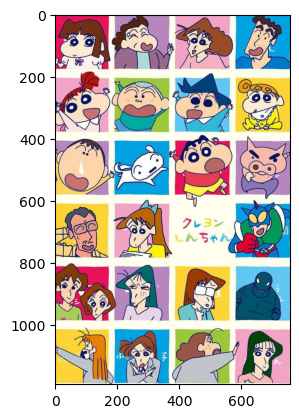

In [3]:
img_path = "data/shin-chan.jpg"

pt_img = read_image(img_path).float() / 255
viz_img(pt_img)

In [ ]:
characters = []
h = 200
w = 190
for i in range(6):
    for j in range(4):
        top = i * h
        left = j * w
        char_img = TVF.crop(pt_img, top, left, h, w)
        char_img = TVF.resize(char_img, [28,28], interpolation=InterpolationMode('nearest'))
        characters.append(char_img)

characters = torch.stack(characters, dim=0) # [B,C,H,W]
print('batch shape:', characters.shape)

batch shape: torch.Size([24, 3, 28, 28])


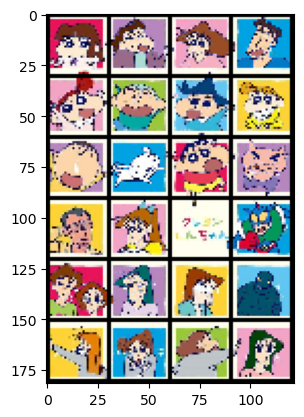

In [10]:
all_img = make_grid(characters, nrow=4)
viz_img(all_img)

diff: tensor(2.1229e-07, grad_fn=<MeanBackward0>)
learnable shape: torch.Size([3])


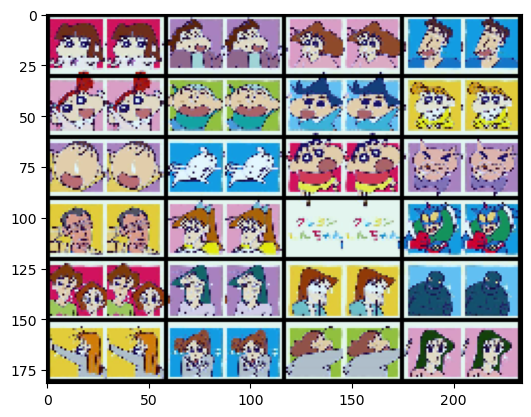

In [ ]:
# BatchNorm:
# 对给个 channel/feature 做归一化 
bn_mean = characters.mean(dim=(0,2,3), keepdim=True)
bn_std = (characters - bn_mean).pow(2).mean(dim=(0,2,3), keepdim=True).sqrt()
bn_img = (characters - bn_mean) / (bn_std.pow(2) + 1e-5).sqrt()

bn = nn.BatchNorm2d(num_features=3, affine=True) # affine 可学变换
bn_img_pt = bn(characters)
print('diff:', torch.linalg.norm((bn_img-bn_img_pt).flatten(2), dim=1).mean())
print('learnable shape:', bn.weight.shape)

all_img = make_grid(torch.cat([bn_img, bn_img_pt], dim=-1), nrow=4, normalize=True)
viz_img(all_img)

diff: tensor(2.6193e-07, grad_fn=<MeanBackward0>)
learnable shape: torch.Size([3, 28, 28])


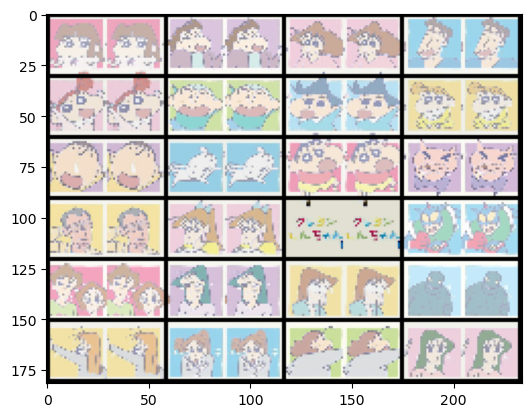

In [ ]:
# LayerNorm:
# 对 batch/sample 做归一化
# pytorch 实现更灵活, normalized_shape 确定要求和的维度
ln_mean = characters.mean(dim=(1,2,3), keepdim=True)
ln_std = (characters - ln_mean).pow(2).mean(dim=(1,2,3), keepdim=True).sqrt()
ln_img = (characters - ln_mean) / (ln_std.pow(2) + 1e-5).sqrt()

B,C,H,W = characters.shape
ln = nn.LayerNorm(normalized_shape=[C,H,W], elementwise_affine=True) # 可学参数和 normalized_shape 对应
ln_img_pt = ln(characters)
print('diff:', torch.linalg.norm((ln_img-ln_img_pt).flatten(2), dim=1).mean())
print('learnable shape:', ln.weight.shape)

all_img = make_grid(torch.cat([ln_img, ln_img_pt], dim=-1), nrow=4, normalize=True)
viz_img(all_img)

diff: tensor(6.3769e-07, grad_fn=<MeanBackward0>)
learnable shape: torch.Size([12])


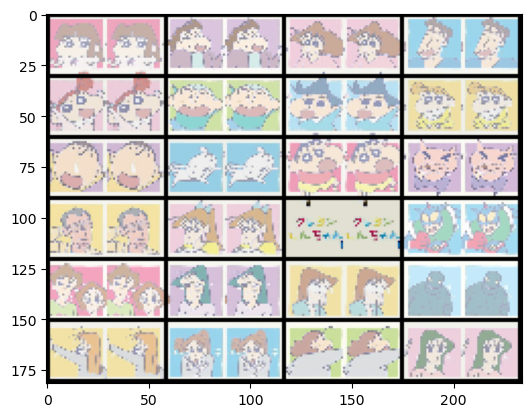

In [15]:
# GroupNorm:
# 把 channel 分成一个个 group, 组内归一化
grp_characters = torch.cat([characters]*4, dim=1)
stack_grp_characters = torch.stack(grp_characters.split(3, dim=1), dim=1) # [B, G, C, H, W]
gn_mean = stack_grp_characters.mean(dim=(2,3,4), keepdim=True)
gn_std = (stack_grp_characters - gn_mean).pow(2).mean(dim=(2,3,4), keepdim=True).sqrt()
gn_img = (stack_grp_characters - gn_mean) / (gn_std.pow(2) + 1e-5).sqrt()
gn_img = gn_img.flatten(1,2) # [B, GC, H, W]

gn = nn.GroupNorm(num_groups=4, num_channels=12, affine=True)
gn_img_pt = gn(grp_characters)
print('diff:', torch.linalg.norm((gn_img-gn_img_pt).flatten(2), dim=1).mean())
print('learnable shape:', gn.weight.shape)

all_img = make_grid(torch.cat([gn_img, gn_img_pt], dim=-1)[:,:3,:,:], nrow=4, normalize=True)
viz_img(all_img)

In [62]:
class CNN(nn.Module):
    def __init__(self, in_c, norm_type='ln'):
        super().__init__()
        self.cnn = nn.Conv2d(in_c, in_c, 5, 1, 2)
        self.relu = nn.ReLU()
        if norm_type =='bn':
            self.norm = nn.BatchNorm2d(in_c)
        elif norm_type == 'ln':
            self.norm = nn.LayerNorm([in_c,28,28])
        elif norm_type == 'rms':
            self.norm = nn.RMSNorm([in_c,28,28])
        else:
            raise ValueError()
    
    def forward(self, x, post_norm=False):
        if not post_norm:
            z = self.norm(x)
            z = self.cnn(z)
            z = self.relu(z)
        else:
            z = self.cnn(x)
            z = self.relu(z)
            z = self.norm(z)
        return x + z

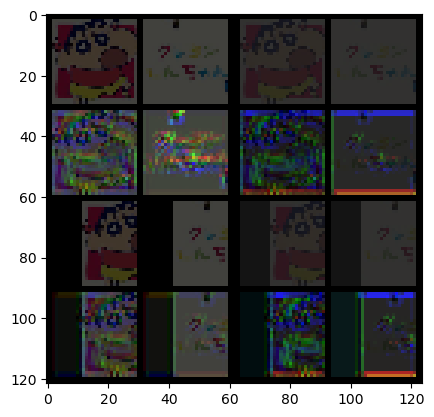

In [73]:
model = CNN(3, 'ln')

in_img = characters[[10,14]]
in_img_aff = TVF.affine(in_img, angle=0, translate=[10,0], scale=1, shear=0)
out_img_pre = model(in_img, False).detach().cpu()
out_img_post = model(in_img, True).detach().cpu()
out_img_pre_aff = model(in_img_aff, False).detach().cpu()
out_img_post_aff = model(in_img_aff, True).detach().cpu()

img_pre = make_grid(torch.cat([in_img, out_img_pre, in_img_aff, out_img_pre_aff], dim=0), nrow=2, normalize=True)
img_post = make_grid(torch.cat([in_img, out_img_post, in_img_aff, out_img_post_aff], dim=0), nrow=2, normalize=True)
viz_img(torch.cat([img_pre, img_post], dim=-1))